In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# import the necessary packages

In [2]:
target_column = 'Price'

In [3]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 150)

In [4]:
def handleOriginal(original, test_df):
    original.insert(0, 'id', range(test_df['id'].max()+1, test_df['id'].max() + 1 + len(original)))

In [5]:
train = pd.read_csv("train.csv")
train_extra = pd.read_csv("training_extra.csv")
original = pd.read_csv("original.csv")
test = pd.read_csv("test.csv")

handleOriginal(original, train_extra)

train['dataset'] = 'train'
train_extra['dataset'] = 'train_extra'
original['dataset'] = 'original'
test['dataset'] = 'test'

data = pd.concat([train, test, original]).reset_index(drop=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552500 entries, 0 to 552499
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    552500 non-null  int64  
 1   Brand                 533943 non-null  object 
 2   Material              535915 non-null  object 
 3   Size                  538899 non-null  object 
 4   Compartments          549875 non-null  float64
 5   Laptop Compartment    537469 non-null  object 
 6   Waterproof            538014 non-null  object 
 7   Style                 536752 non-null  object 
 8   Color                 533140 non-null  object 
 9   Weight Capacity (kg)  549660 non-null  float64
 10  Price                 349875 non-null  float64
 11  dataset               552500 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 50.6+ MB


In [7]:
data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,dataset
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875,train
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056,train
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320,train
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793,train
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312,train


<Axes: xlabel='dataset', ylabel='count'>

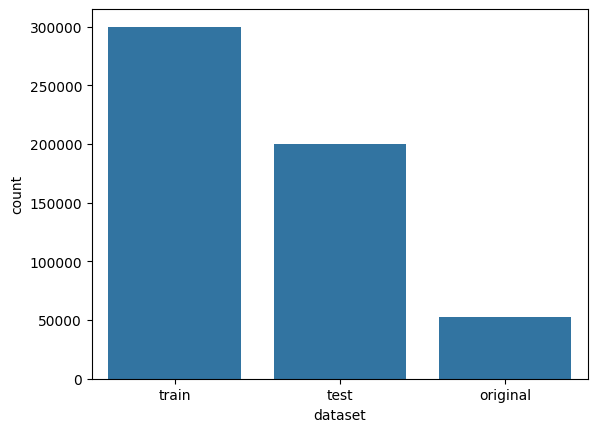

In [8]:
sns.countplot(data,x="dataset")

In [9]:
data.isna().sum().sort_values(ascending=False)

Price                   202625
Color                    19360
Brand                    18557
Material                 16585
Style                    15748
Laptop Compartment       15031
Waterproof               14486
Size                     13601
Weight Capacity (kg)      2840
Compartments              2625
id                           0
dataset                      0
dtype: int64

In [10]:
def show_missing_values(data, palette="viridis"):
    missing_values = data.isna().sum().sort_values(ascending=False)
    sns.barplot(x=missing_values.values, y=missing_values.index,palette=palette)

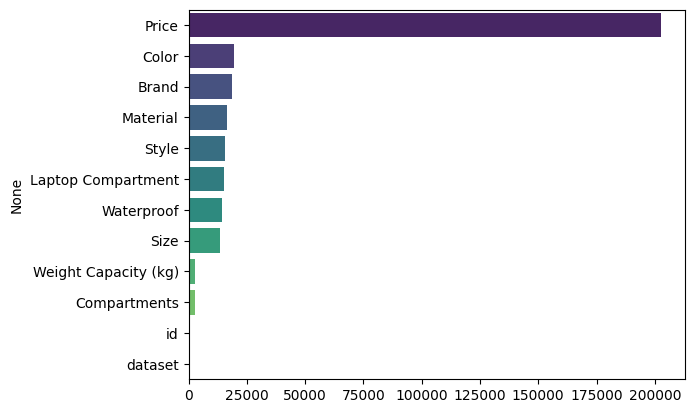

In [11]:
show_missing_values(data)

<Axes: xlabel='Weight Capacity (kg)', ylabel='Count'>

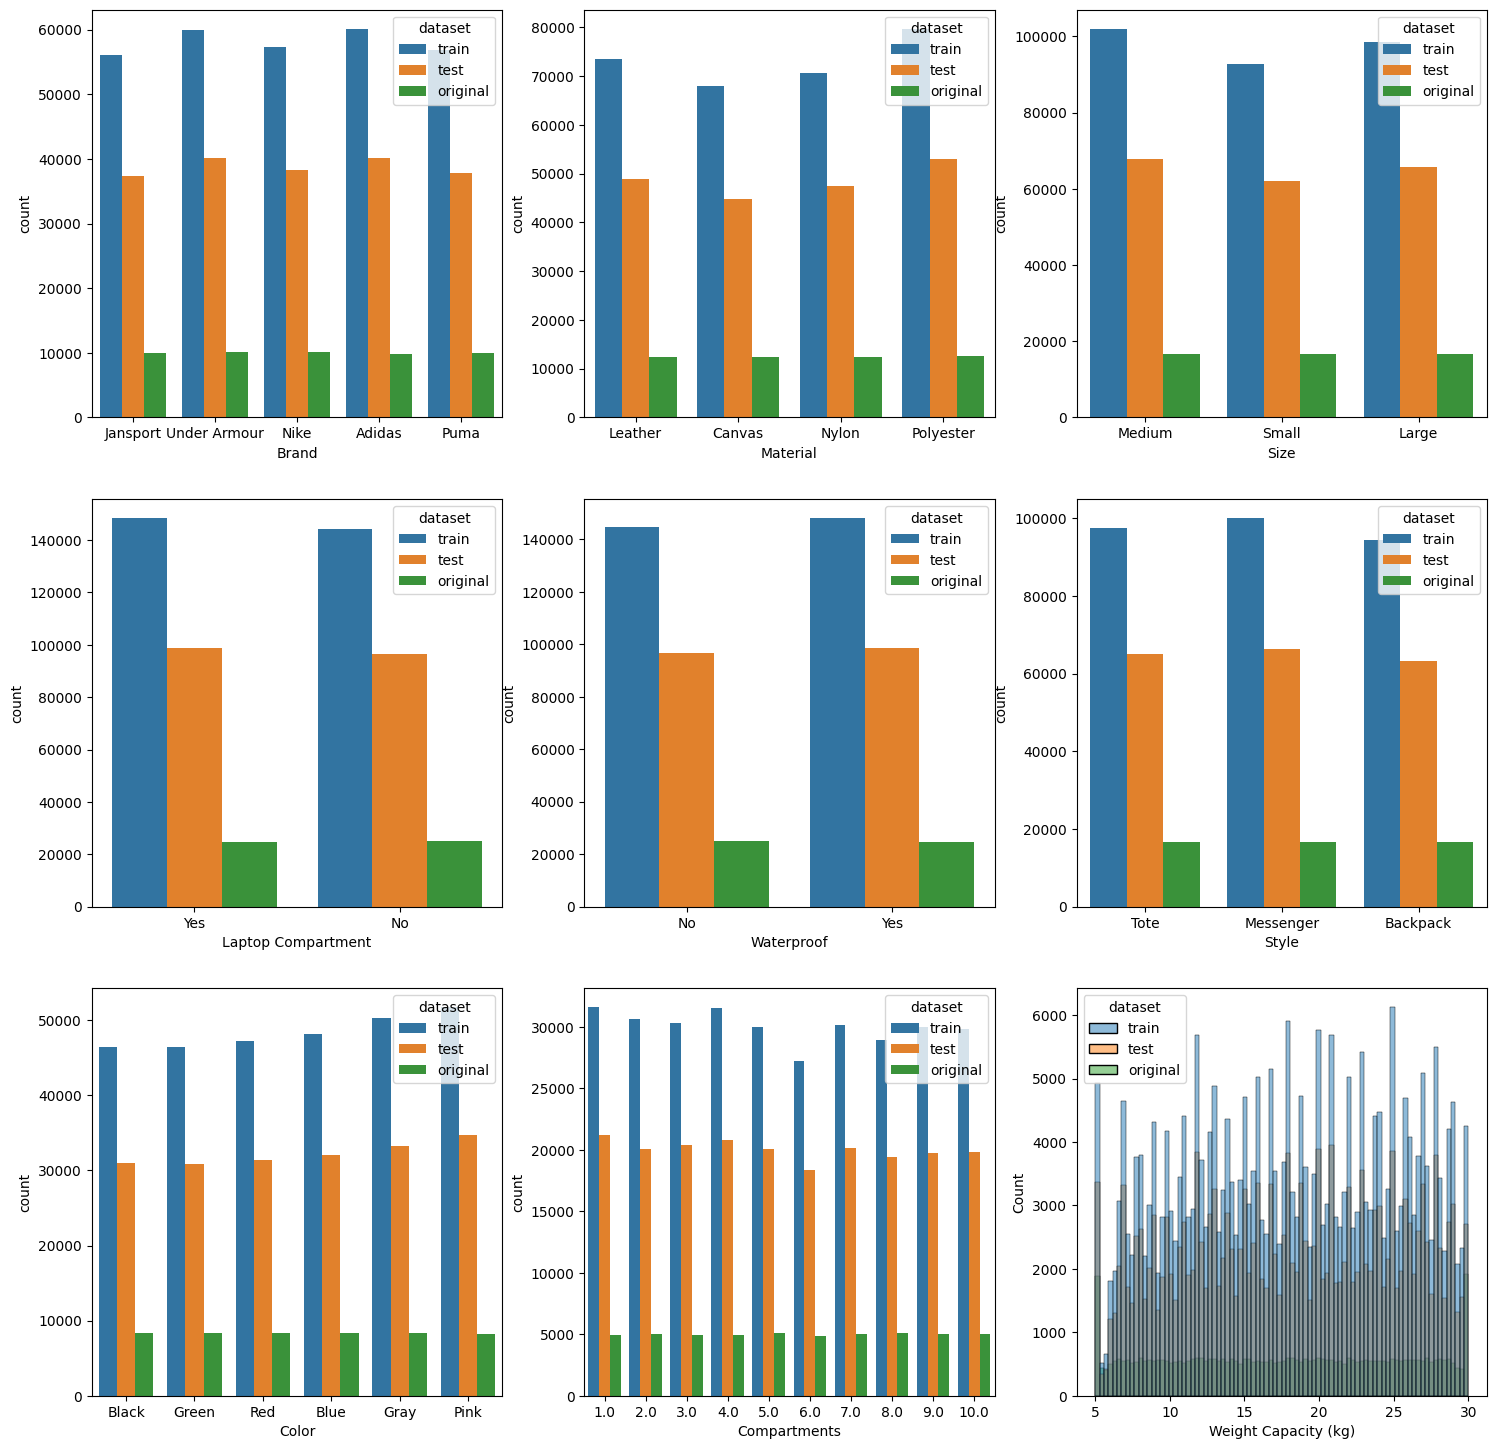

In [12]:
fig, axes = plt.subplots(3,3,figsize=(18,18))

sns.countplot(data,x="Brand",hue='dataset',ax=axes[0][0])
sns.countplot(data,x="Material",hue='dataset',ax=axes[0][1])
sns.countplot(data,x="Size",hue='dataset',ax=axes[0][2])

sns.countplot(data,x="Laptop Compartment",hue='dataset',ax=axes[1][0])
sns.countplot(data,x="Waterproof",hue='dataset',ax=axes[1][1])
sns.countplot(data,x="Style",hue='dataset',ax=axes[1][2])

sns.countplot(data,x="Color",hue='dataset',ax=axes[2][0])
sns.countplot(data,x="Compartments",hue='dataset',ax=axes[2][1])
sns.histplot(data,x="Weight Capacity (kg)",hue='dataset',ax=axes[2][2])

<Axes: xlabel='Weight Capacity (kg)', ylabel='Count'>

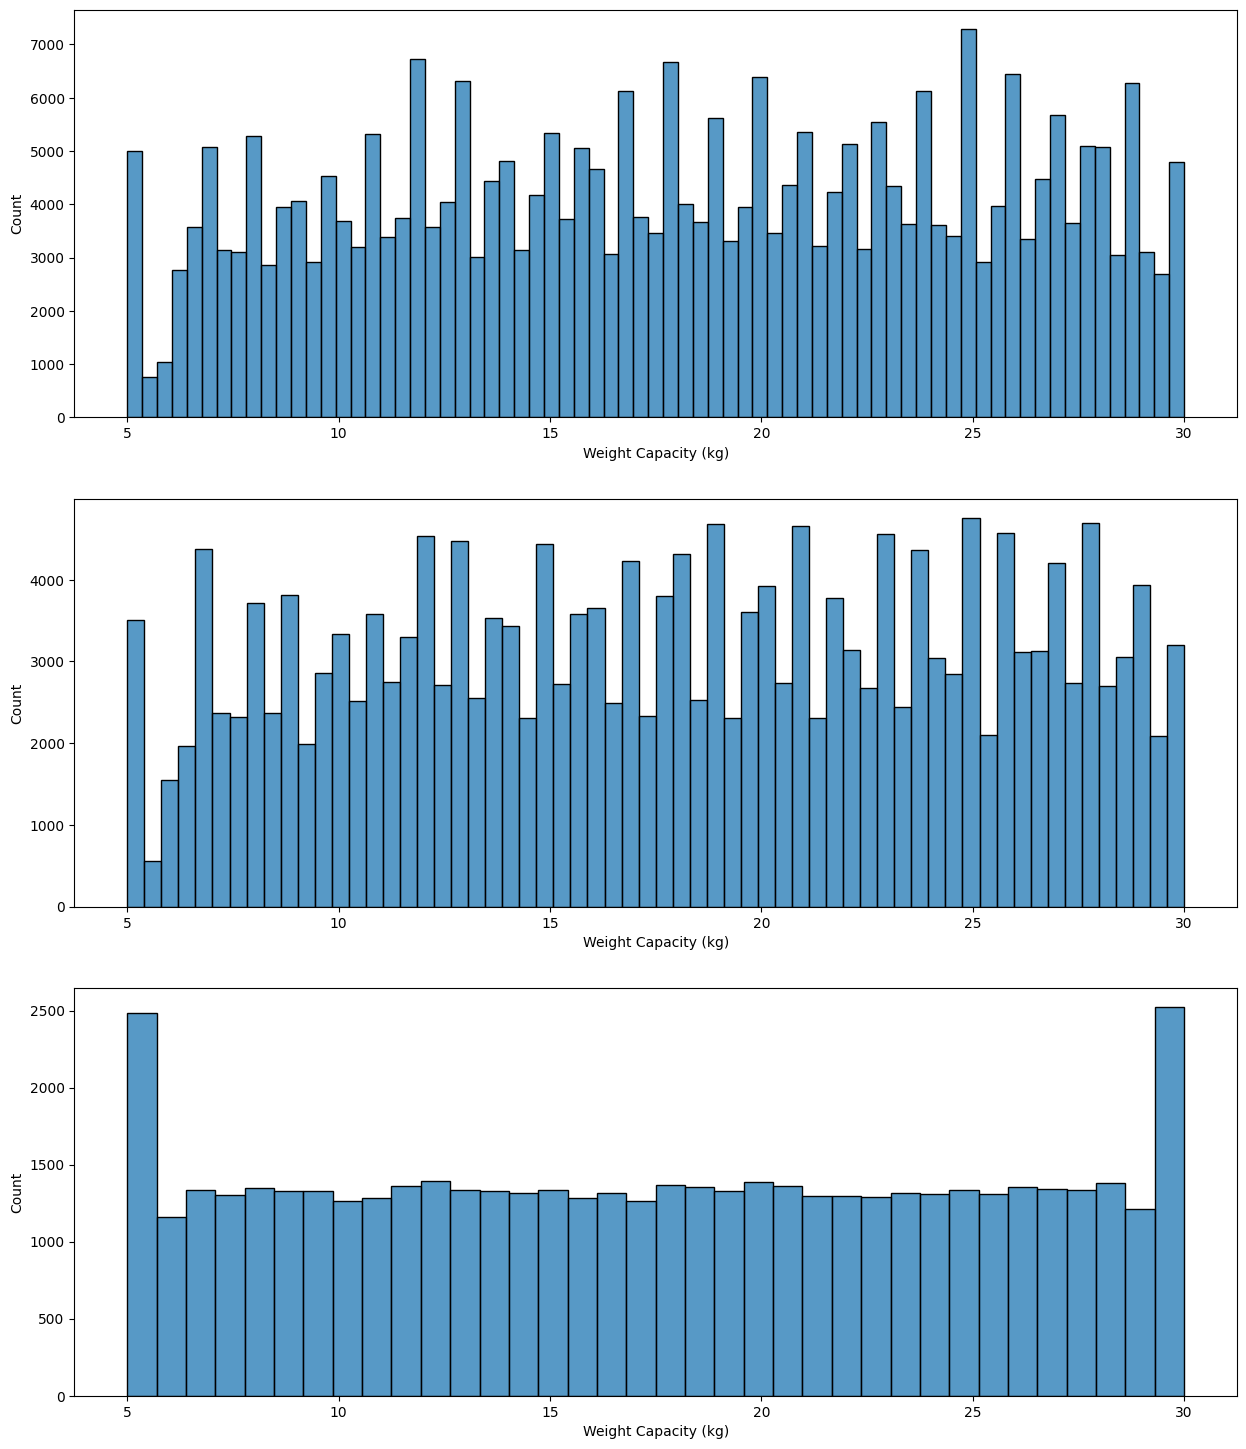

In [13]:
fig, axes = plt.subplots(3,1,figsize=(15,18))

sns.histplot(data[data['dataset']=='train'],x="Weight Capacity (kg)",ax=axes[0])
sns.histplot(data[data['dataset']=='test'],x="Weight Capacity (kg)",ax=axes[1])
sns.histplot(data[data['dataset']=='original'],x="Weight Capacity (kg)",ax=axes[2])

Original dataset is very clean with all the capacities having the same distribution. Other than that, looks relatively balanced among all datasets. 

<Axes: xlabel='Price', ylabel='Count'>

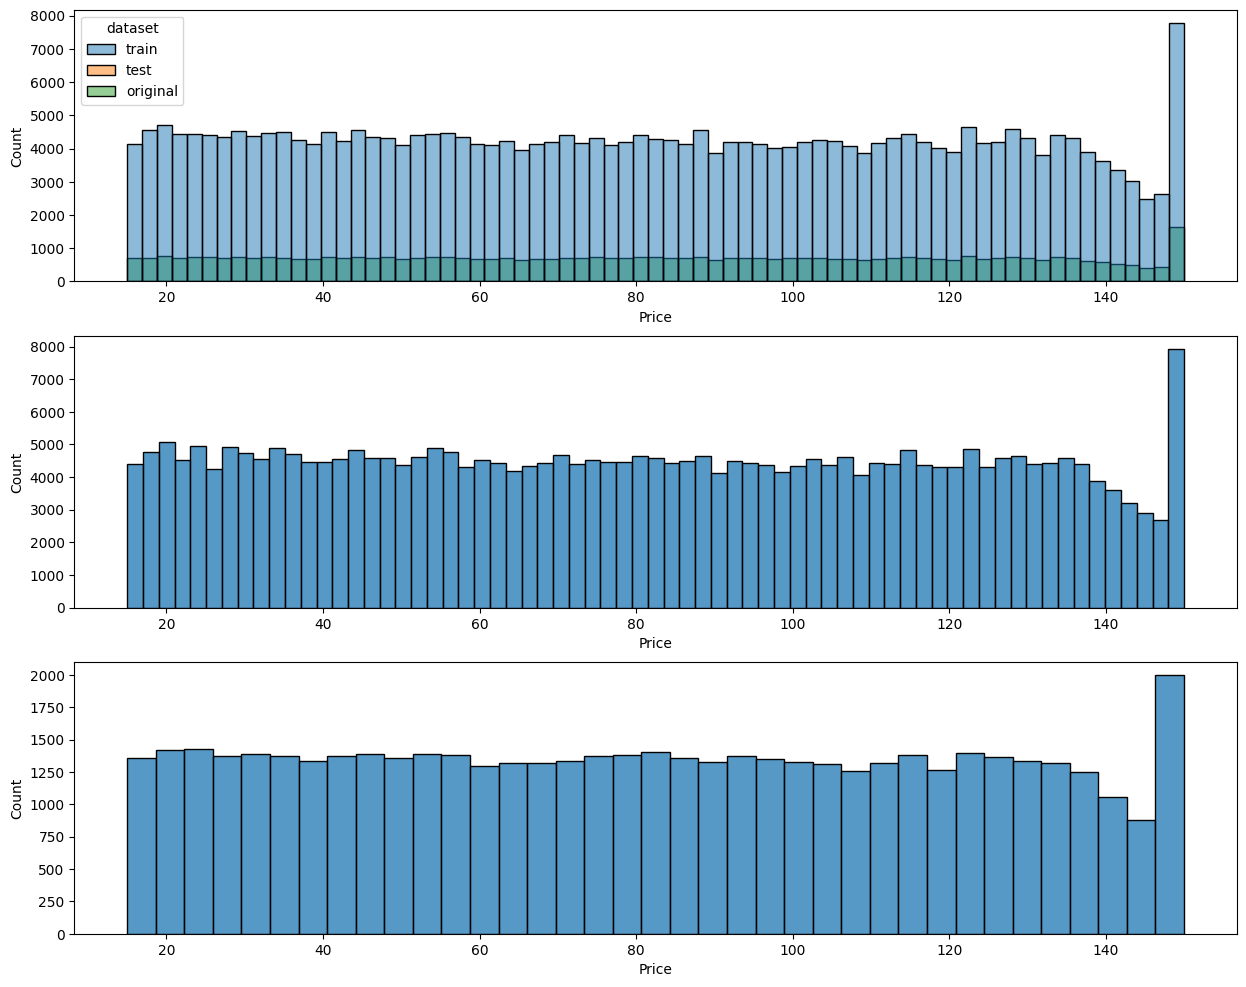

In [14]:
fig, axes = plt.subplots(3,1,figsize=(15,12))

sns.histplot(data,x=target_column,hue='dataset',ax=axes[0])
sns.histplot(data[data['dataset']=='train'],x=target_column,ax=axes[1])
sns.histplot(data[data['dataset']=='original'],x=target_column,ax=axes[2])

Uniform distribution is surprising here for Price.

<Axes: xlabel='Price'>

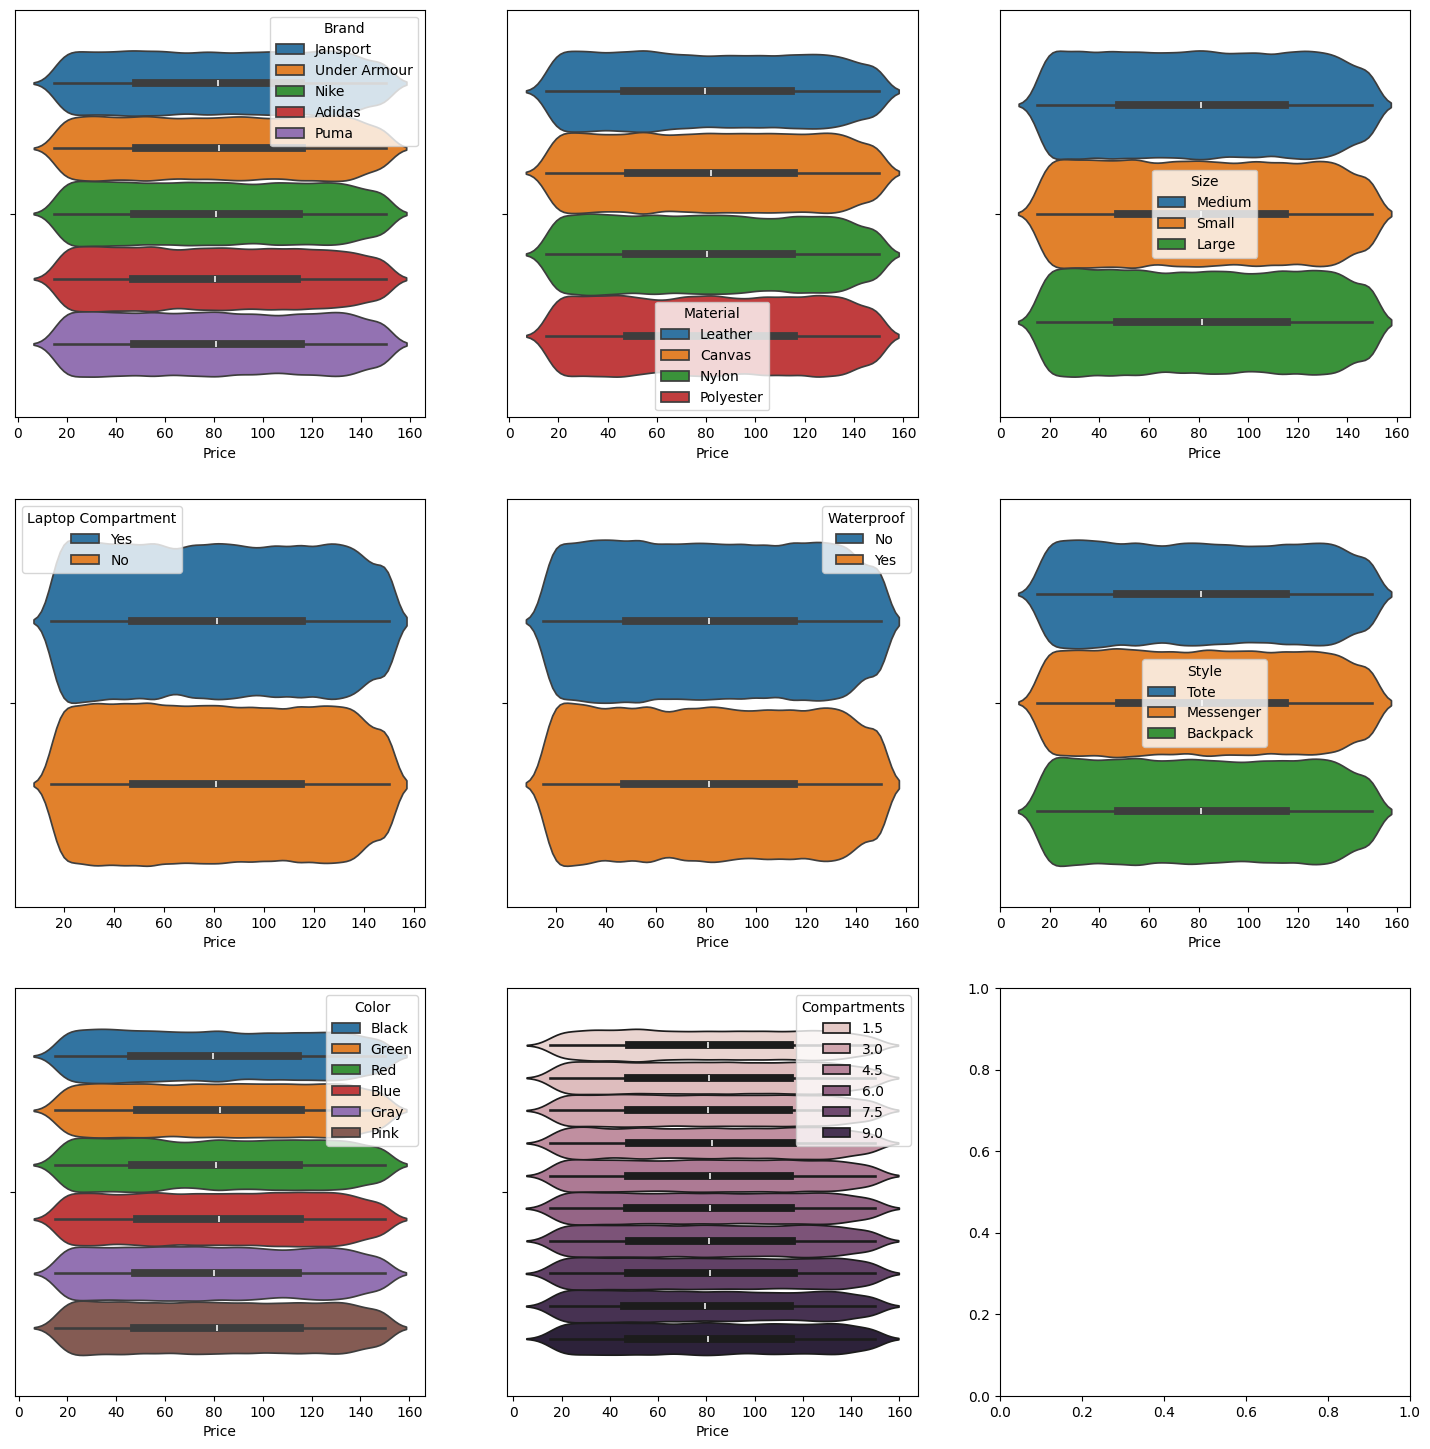

In [ ]:
fig, axes = plt.subplots(3,3,figsize=(18,18))

sns.violinplot(data,x=target_column,hue='Brand',ax=axes[0][0])
sns.violinplot(data,x=target_column,hue='Material',ax=axes[0][1])
sns.violinplot(data,x=target_column,hue='Size',ax=axes[0][2])

sns.violinplot(data,x=target_column,hue='Laptop Compartment',ax=axes[1][0])
sns.violinplot(data,x=target_column,hue='Waterproof',ax=axes[1][1])
sns.violinplot(data,x=target_column,hue='Style',ax=axes[1][2])

sns.violinplot(data,x=target_column,hue='Color',ax=axes[2][0])
sns.violinplot(data,x=target_column,hue='Compartments',ax=axes[2][1])

Distributions here look very similar across the categories.

<Axes: xlabel='Material', ylabel='count'>

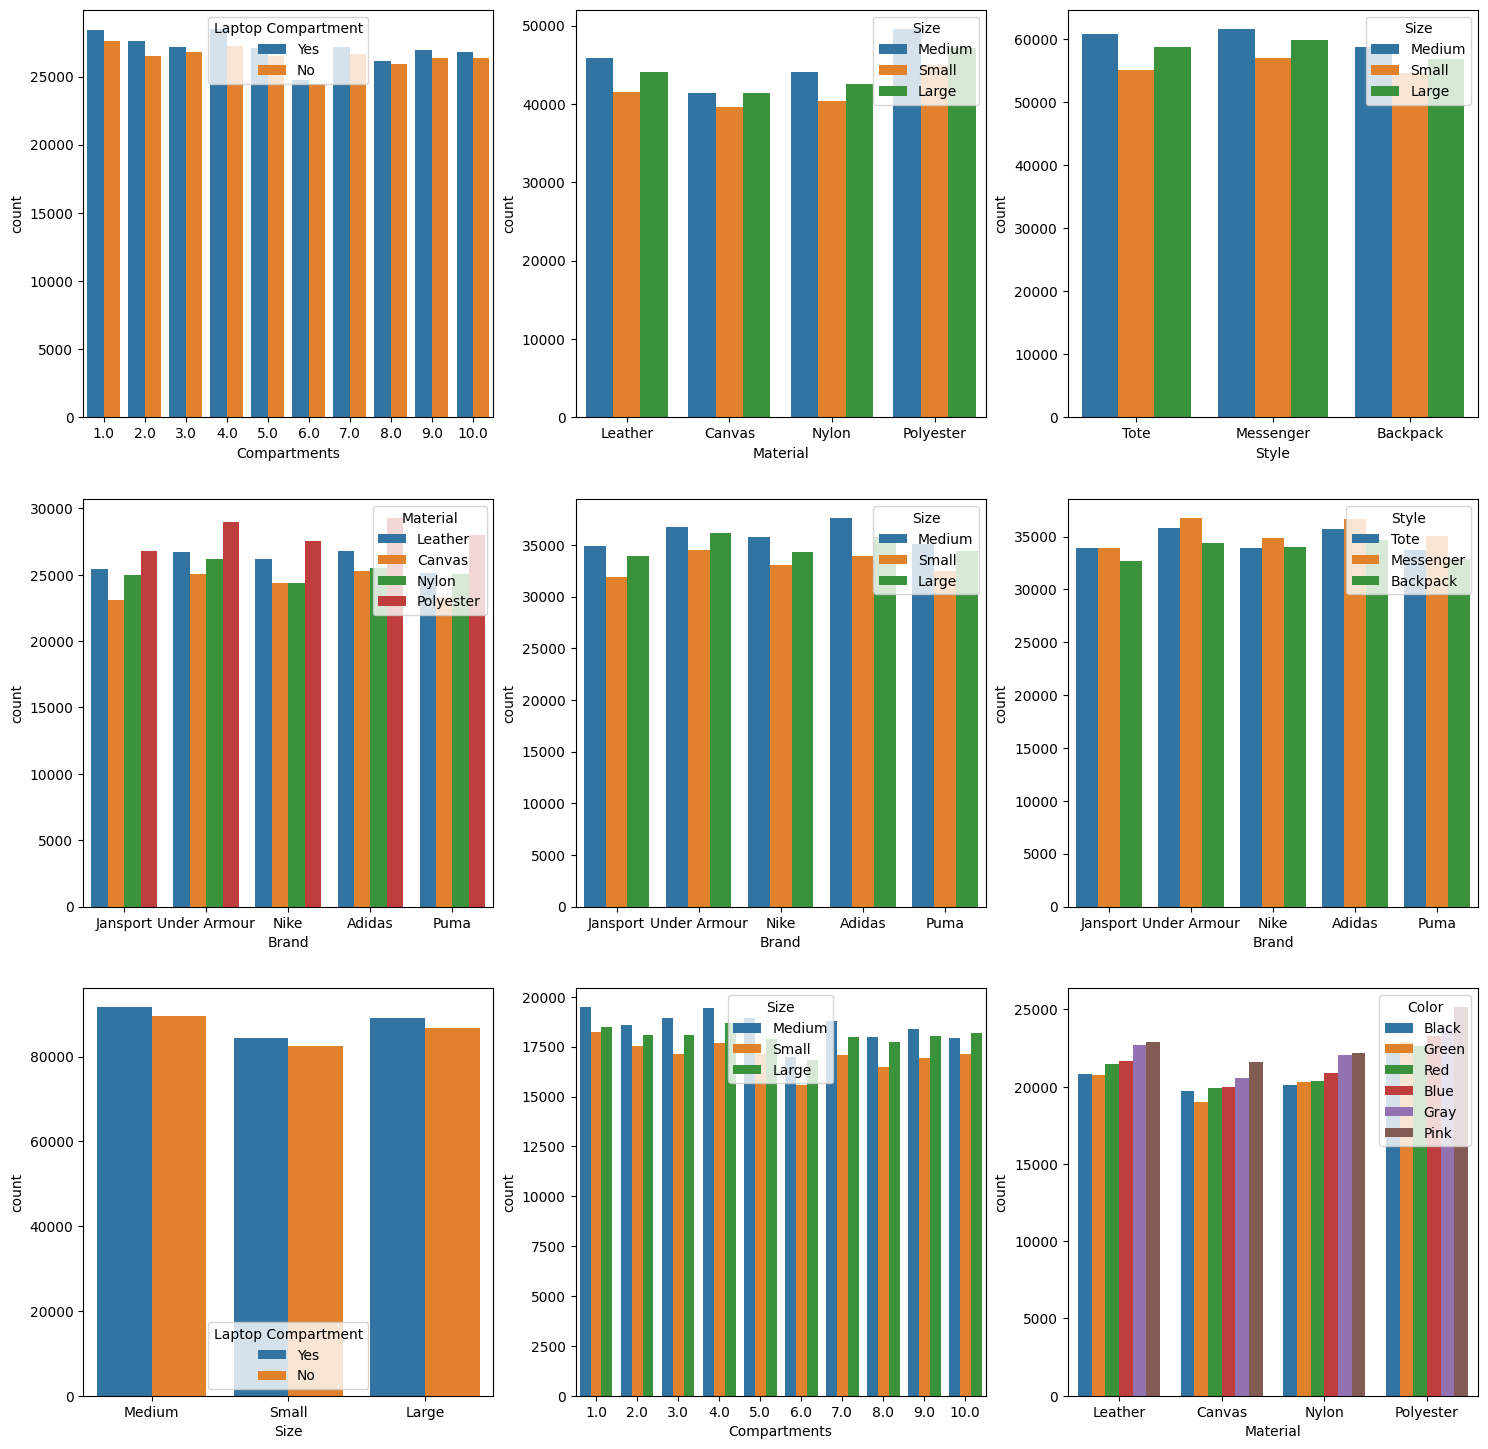

In [19]:
fig, axes = plt.subplots(3,3,figsize=(18,18))

sns.countplot(data,x="Compartments",hue="Laptop Compartment",ax=axes[0][0])
sns.countplot(data,x="Material",hue="Size",ax=axes[0][1])
sns.countplot(data,x="Style",hue="Size",ax=axes[0][2])

sns.countplot(data,x="Brand",hue="Material",ax=axes[1][0])
sns.countplot(data,x="Brand",hue="Size",ax=axes[1][1])
sns.countplot(data,x="Brand",hue="Style",ax=axes[1][2])

sns.countplot(data,x="Size",hue="Laptop Compartment",ax=axes[2][0])
sns.countplot(data,x="Compartments",hue="Size",ax=axes[2][1])
sns.countplot(data,x="Material",hue="Color",ax=axes[2][2])

Looking at bivariate categorical distributions based on intuitions also doesn't reveal anything. 

<Axes: xlabel='Price_binned', ylabel='Weight Capacity (kg)_binned'>

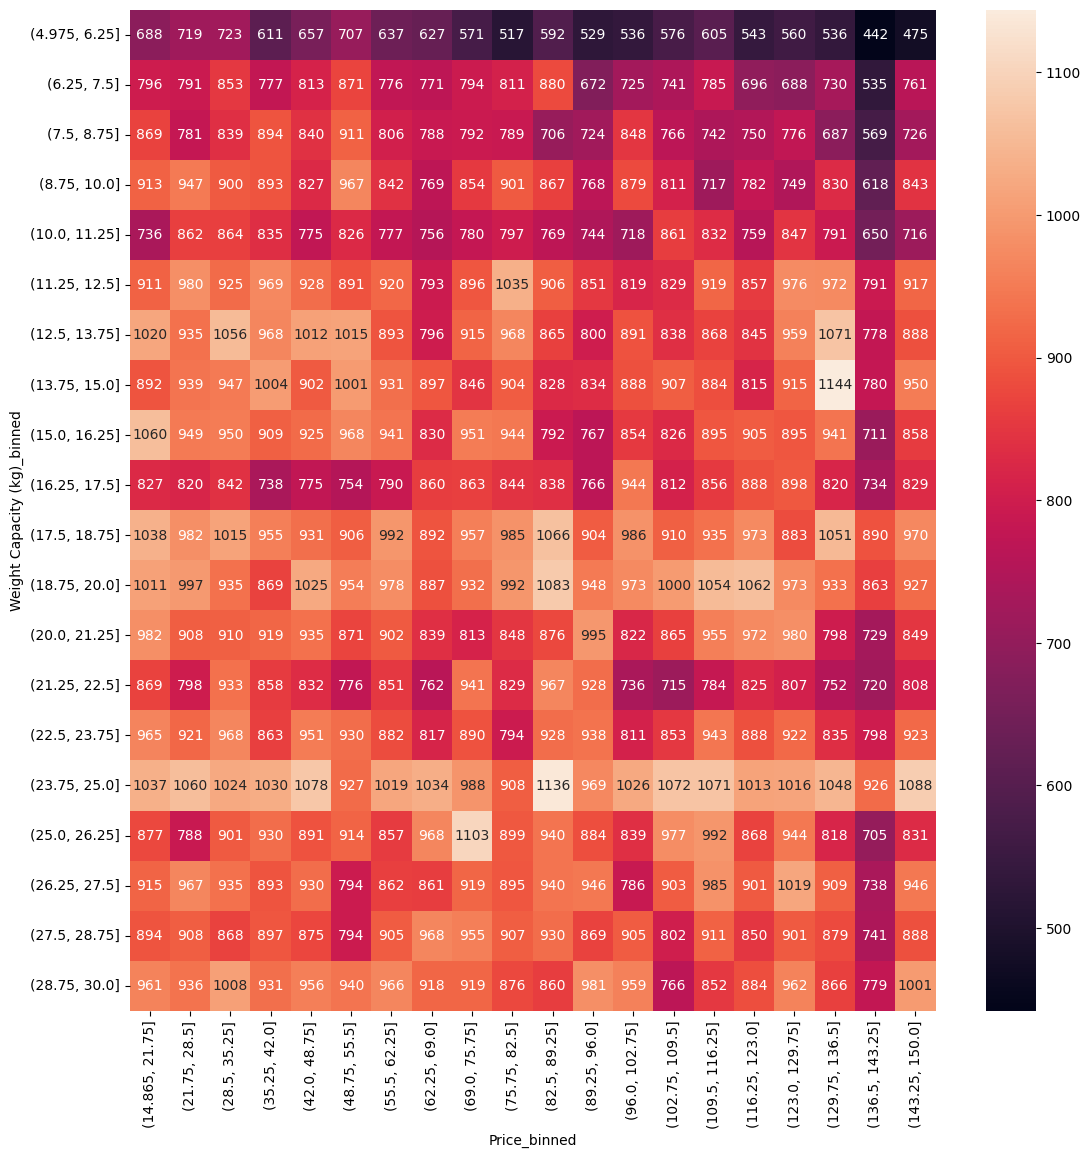

In [40]:
fig, axes = plt.subplots(1,1,figsize=(13,13))
data_copy = data.copy()

bins = 20
data_copy['Weight Capacity (kg)_binned'] = pd.cut(data_copy['Weight Capacity (kg)'], bins=bins)
data_copy['Price_binned'] = pd.cut(data_copy['Price'], bins=bins)

heatmap_data = pd.crosstab(data_copy['Weight Capacity (kg)_binned'], data_copy['Price_binned'])
sns.heatmap(heatmap_data, annot=True,fmt="d")

<Axes: ylabel='Price'>

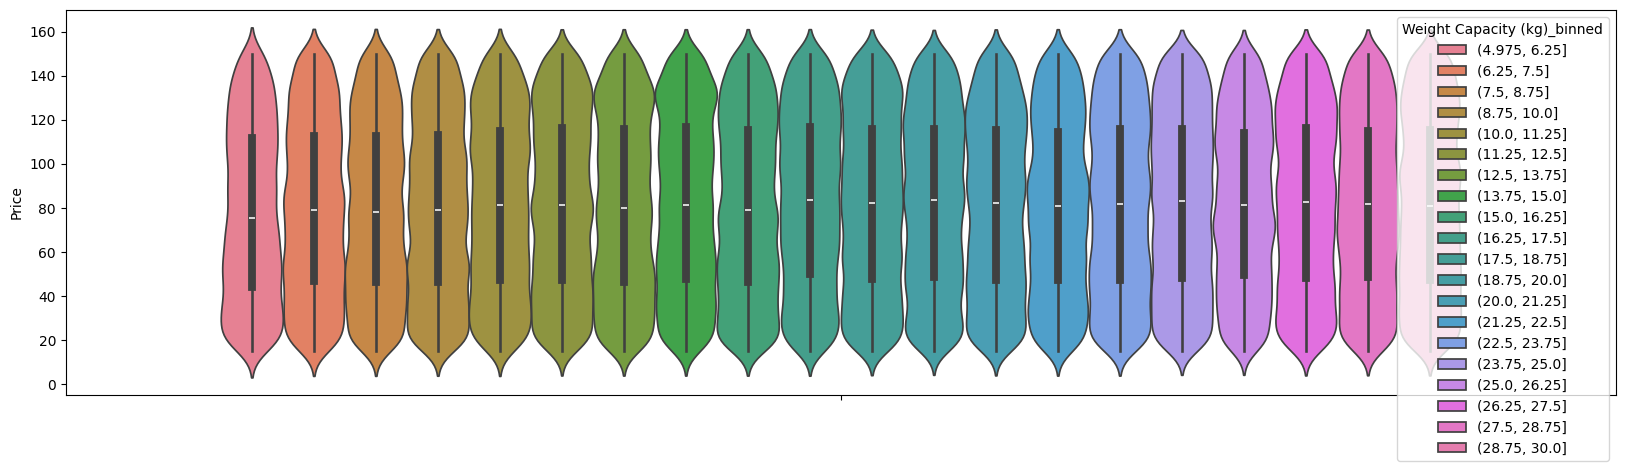

In [50]:
fig, axes = plt.subplots(1,1,figsize=(20,5))
sns.violinplot(data_copy,y="Price",hue="Weight Capacity (kg)_binned")

Dataset is very noisy. Certain value ranges do feel in home range. However, the variance of the means is low and is resistant to change. This shows that patterns aren't obvious.